<a href="https://colab.research.google.com/github/jun-0123/2024_2_DL/blob/main/%EB%94%A5%EB%9F%AC%EB%8B%9D_LSTM_%EB%AA%A8%EB%8D%B8%EB%A7%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')


In [ ]:
pip install finance-datareader

In [ ]:
import FinanceDataReader as fdr

In [ ]:
samsung = fdr.DataReader('005930')

- Open: 시가
- High: 고가
- Low: 저가
- Close: 종가
- Volume: 거래량
- Change: 대비

In [ ]:
samsung.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2024-09-20,63800,64700,63000,63000,32746056,-0.001585
2024-09-23,62300,63500,62200,62600,28542376,-0.006349
2024-09-24,62800,63400,62400,63200,26957500,0.009585
2024-09-25,63800,64200,62200,62200,28652438,-0.015823
2024-09-26,63900,64900,63800,64500,20793840,0.036977


In [ ]:
# Ford(F), 1980-01-01 ~ 2019-12-30 (40년 데이터)
ford = fdr.DataReader('F', '1980-01-01', '2024-09-25')

### **주가데이터 가져오기**

In [ ]:
STOCK_CODE = '005930'

In [ ]:
stock = fdr.DataReader(STOCK_CODE)

In [ ]:
stock.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2000-06-08,6660,6960,6530,6530,1171017,NaN
2000-06-09,6600,7040,6530,7020,1277296,0.075038
2000-06-12,7200,7280,7030,7190,990305,0.024217
2000-06-13,7060,7099,6870,7060,849970,-0.018081
2000-06-14,7230,7639,7089,7640,1260474,0.082153


In [ ]:
stock.index

DatetimeIndex(['2000-06-08', '2000-06-09', '2000-06-12', '2000-06-13',
               '2000-06-14', '2000-06-15', '2000-06-16', '2000-06-19',
               '2000-06-20', '2000-06-21',
               ...
               '2024-09-10', '2024-09-11', '2024-09-12', '2024-09-13',
               '2024-09-19', '2024-09-20', '2024-09-23', '2024-09-24',
               '2024-09-25', '2024-09-26'],
              dtype='datetime64[ns]', name='Date', length=6000, freq=None)

In [ ]:
stock['Year'] = stock.index.year
stock['Month'] = stock.index.month
stock['Day'] = stock.index.day

Text(0, 0.5, 'price')

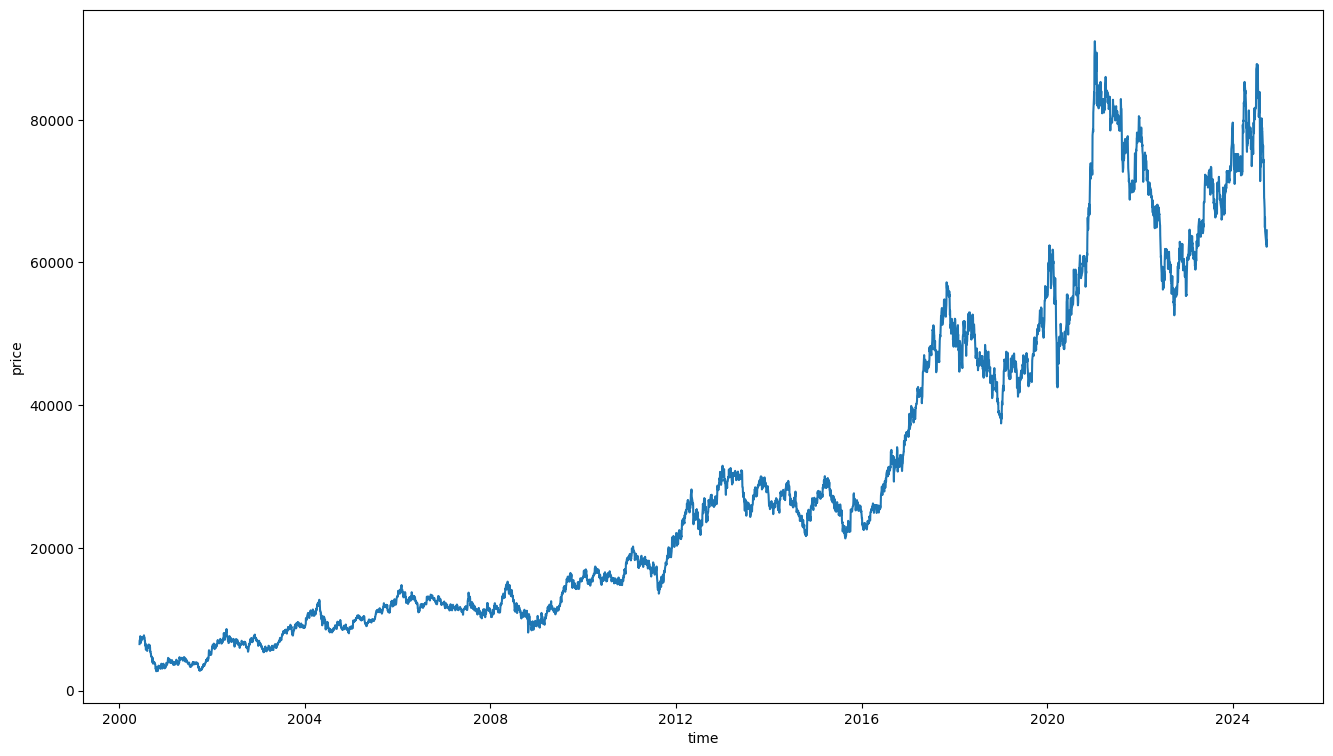

In [ ]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=stock['Close'], x=stock.index)
plt.xlabel('time')
plt.ylabel('price')

### 데이터 전처리

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
# 스케일 후 columns
scaled = scaler.fit_transform(stock[scale_cols])
scaled

array([[0.07375415, 0.07190083, 0.07296089, 0.04304973, 0.01296719],
       [0.0730897 , 0.07272727, 0.07296089, 0.04860088, 0.01414406],
       [0.07973422, 0.07520661, 0.07854749, 0.05052679, 0.01096608],
       ...,
       [0.69545958, 0.65495868, 0.6972067 , 0.68505721, 0.29851225],
       [0.70653378, 0.66322314, 0.69497207, 0.67372833, 0.31728104],
       [0.7076412 , 0.67045455, 0.71284916, 0.69978475, 0.23025933]])

In [ ]:
df = pd.DataFrame(scaled, columns=scale_cols)

### train / test 분할

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', axis=1), df['Close'], test_size=0.2, random_state=0, shuffle=False)


In [ ]:
x_train.shape, y_train.shape

((4800, 4), (4800,))

In [ ]:
x_test.shape, y_test.shape

((1200, 4), (1200,))

In [ ]:
x_train

,Open,High,Low,Volume
0,0.073754,0.071901,0.072961,0.012967
1,0.073090,0.072727,0.072961,0.014144
2,0.079734,0.075207,0.078547,0.010966
3,0.078184,0.073337,0.076760,0.009412
4,0.080066,0.078915,0.079207,0.013958
...,...,...,...,...
4795,0.591362,0.551653,0.585475,0.102508
4796,0.589147,0.550620,0.581006,0.128488
4797,0.578073,0.539256,0.574302,0.090647
4798,0.573643,0.543388,0.576536,0.072821


### TensroFlow Dataset을 활용한 시퀀스 데이터셋 구성

In [ ]:
import tensorflow as tf

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
WINDOW_SIZE=20
BATCH_SIZE=32

In [ ]:
# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [ ]:
# 아래의 코드로 데이터셋의 구성을 확인해 볼 수 있습니다.
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


### 모델

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [ ]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [ ]:
# earlystopping은 10번 epoch 동안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)

# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'checkpointer.weights.h5')  # 파일 확장자를 .weights.h5로 수정
checkpoint = ModelCheckpoint(filename,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)


In [ ]:
history = model.fit(train_data,
                    validation_data=(test_data),
                    epochs=50,
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
    148/Unknown 12s 21ms/step - loss: 2.7268e-04 - mse: 5.4536e-04
Epoch 1: val_loss improved from inf to 0.00155, saving model to tmp/checkpointer.weights.h5
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - loss: 2.6987e-04 - mse: 5.3974e-04 - val_loss: 0.0015 - val_mse: 0.0031
Epoch 2/50
149/150 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.1474e-05 - mse: 4.2947e-05
Epoch 2: val_loss improved from 0.00155 to 0.00084, saving model to tmp/checkpointer.weights.h5
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 2.1789e-05 - mse: 4.3578e-05 - val_loss: 8.4103e-04 - val_mse: 0.0017
Epoch 3/50
149/150 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 2.0694e-05 - mse: 4.1387e-05
Epoch 3: val_loss improved from 0.00084 to 0.00058, saving model to tmp/checkpointer.weights.h5
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 2.1035e-05 - mse: 4.2069e-05 - val_loss: 5.8157e-04 - val_mse: 0.0012
Epoch 4/50
146/150 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.1334e-05 - mse: 4.2668e-05
Epoch 4: va

In [ ]:
model.load_weights(filename)

In [ ]:
pred = model.predict(test_data)

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [ ]:
pred.shape

(1180, 1)

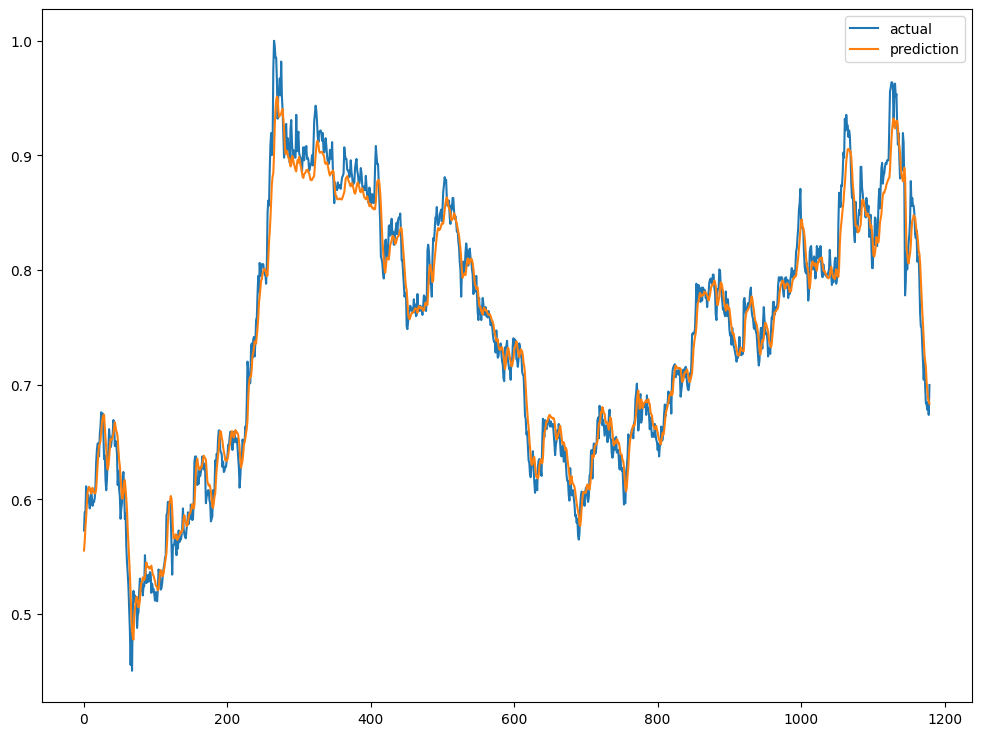

In [ ]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()